In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
"""
MODEL
"""
num_classes = 0
# Use a Ladder CNN in addition to the image encoder?
use_cnn = False
# Run the resizing operations after the CNN? (might preserve fine pixel-level details better)
resize_before_cnn = True

# Use LoRA on the mask decoder? (if False, trains the whole decoder)
mask_lora = True
mask_r = 8

# use LoRa on the image encoder transformer?
vit_lora = False
vit_r = 8

# train the image encoder's patch embedding CNN? Highly recommended.
vit_patch_embed = True

num_refinement_steps = 0

"""
TRAINING
"""
run_grad = True

focal_scale = 20
mse_scale = 1
dice_scale = 1
cls_scale = 1

"""
DATA
"""
use_valid = True
cls_ids = None # any
train_size = None # images
valid_size = 20 # images

use_masks = True
grow_masks = False
growth_radius = 15

# train on semantic segmentation or point/box-to-mask?
tasks = ["sem_seg","point","box","cls"]

points_per_mask = 1

In [3]:
import sys
import os
# sys.path.append(os.path.relpath("./segment-anything"))
# inserting to front instead:
sys.path.insert(0, os.path.relpath("./segment-anything"))
import segment_anything

%cd datasets/
from fine_tune.configs.screws import *
%cd ..

/home/andrewhealey/autodistill-seggpt/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Segment Anything custom imported
/home/andrewhealey/sam-fine-tuning/datasets
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Yolov5_seg-10 in coco-segmentation:: 100%|██████████| 1791/1791 [00:00<00:00, 3804.11it/s]


/home/andrewhealey/sam-fine-tuning


In [4]:
import supervision as sv
from fine_tune.datasets import extract_classes_from_dataset,shrink_dataset_to_size

train_dataset = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/train",
    annotations_path=f"{dataset.location}/train/_annotations.coco.json",
    force_masks=use_masks
)

if train_size is not None:
    train_dataset = shrink_dataset_to_size(train_dataset,train_size)

if cls_ids is not None:
    print("Selecting classes",[train_dataset.classes[i] for i in cls_ids])
    train_dataset = extract_classes_from_dataset(train_dataset,cls_ids)

if use_valid:
    valid_dataset = sv.DetectionDataset.from_coco(
        images_directory_path=f"{dataset.location}/valid",
        annotations_path=f"{dataset.location}/valid/_annotations.coco.json",
        force_masks=use_masks
    )
else:
    valid_dataset = train_dataset

if valid_size is not None:
    valid_dataset = shrink_dataset_to_size(valid_dataset,valid_size)

if cls_ids is not None:
    valid_dataset = extract_classes_from_dataset(valid_dataset,cls_ids)

In [5]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: andrewhealey (roboflow2). Use `wandb login --relogin` to force relogin


True

In [6]:
if use_valid:
    valid_names = set(k.split(".rf")[0] for k in valid_dataset.images.keys())
    train_names = set(k.split(".rf")[0] for k in train_dataset.images.keys())

    # Check that there's no training/valid pollution
    assert len(valid_names.intersection(train_names)) == 0,"There is overlap between the training and validation sets."

In [7]:
from persam.load import load_predictor
from fine_tune.samed import LoRA_Mask_Decoder,LoRA_Tiny_Image_Encoder
from fine_tune.ladder_cnn import CNN_SAM

predictor = load_predictor("vit_t",num_classes=num_classes)

if mask_lora:
    lora_mask_decoder = LoRA_Mask_Decoder(predictor.model.mask_decoder,r=mask_r)
    mask_decoder = lora_mask_decoder.mask_decoder.cuda()
else:
    mask_decoder = predictor.model.mask_decoder

if vit_lora:
    lora_image_encoder = LoRA_Tiny_Image_Encoder(predictor.model.image_encoder,r=vit_r).cuda()
    image_encoder = lora_image_encoder.image_encoder
else:
    image_encoder = predictor.model.image_encoder

if use_cnn:
    cnn_sam = CNN_SAM(resize_before_cnn=resize_before_cnn).to("cuda")
else:
    cnn_sam = None

{'num_classes': 0}


Initializing zero-element tensors is a no-op


In [8]:
if use_masks:

    from random import choice
    img_name,dets = (list(train_dataset.annotations.items()))[11]
    img = train_dataset.images[img_name]
    predictor.set_image(img)
    mask = choice(list(dets))[1]

    to_size = 256
    import cv2
    reshaped_mask = cv2.resize(((mask.astype(float) - 0.5) * 5),(to_size,to_size),interpolation=cv2.INTER_NEAREST)

    # predictor.features = predictor.features[0]
    masks_np,_,logits = predictor.predict(
        mask_input=reshaped_mask[None,...],
        multimask_output=True
    )


    # masks_np,*_ = predictor.predict(
    #     mask_input=logits[None,0],
    #     multimask_output=False
    # )


    # print(logits)

    from PIL import Image
    # Image.fromarray(logits[0]>0).convert("RGB")
    # Image.fromarray(reshaped_mask>0).convert("RGB")
    Image.fromarray(masks_np[0]).convert("RGB")
    # Image.fromarray(reshaped_mask.astype(float) * 255).convert("RGB")

In [9]:
from fine_tune.common import grow_dataset_masks

if grow_masks:
    grow_dataset_masks(train_dataset,growth_radius=growth_radius)
    grow_dataset_masks(valid_dataset,growth_radius=growth_radius)

In [10]:
from fine_tune.common import SamBoxDataset, SamPointDataset, SamNextMaskDataset, RandomPointDataset, SamDummyMaskDataset, SamSemSegDataset, SamComboDataset, get_max_iou_masks

import torch
device = torch.device('cuda:0')

from torch.utils.data import ConcatDataset

dataset_makers = {
    "sem_seg": lambda ds: SamSemSegDataset(ds,predictor,device),
    "box": lambda ds: SamBoxDataset(ds,predictor,device),
    "point": lambda ds: SamPointDataset(ds,predictor,device,points_per_mask=1),
    "cls": lambda ds: SamMidasBinaryClassification(ds,predictor,device),
    "dummy": lambda ds: SamDummyMaskDataset(ds,predictor,device),
}

def prep_datasets(ds):
    datasets = []
    for task in tasks:
        datasets.append(dataset_makers[task](ds))
    return SamComboDataset(datasets)

curr_dataset = prep_datasets(train_dataset)
valid_curr_dataset = prep_datasets(valid_dataset)

100%|██████████| 20/20 [00:00<00:00, 72503.09it/s]


In [11]:
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
import numpy as np

# Hyperparameters
initial_lr = 2e-4
weight_decay = 0.1


warmup_steps = 500
total_steps = 150_000
batch_size = 5 # perform gradient accumulation for this--they do 256 images per batch.
log_period = 200 # a few batches
eval_period = 500
wandb_log_period = 20

lr_decay_steps = [2/3., 0.95]
lr_decay_steps = [int(total_steps * step) for step in lr_decay_steps]

lr_decay_factor = 0.1

combined_params = list(predictor.model.mask_decoder.parameters())
if use_cnn: combined_params += list(cnn_sam.parameters())
if vit_patch_embed: combined_params += list(image_encoder.patch_embed.parameters())
optimizer = optim.AdamW(combined_params, lr=initial_lr, betas=(0.9, 0.999), weight_decay=weight_decay) # criterion = torch.nn.CrossEntropyLoss()

num_params = sum([np.prod(p.size()) for p in combined_params if p.requires_grad])
print(f"Total trainable parameters: {num_params}")

# Learning rate warmup schedule
def warmup_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
    return 1.0

warmup_scheduler = LambdaLR(optimizer, lr_lambda=warmup_lambda)

# Step-wise learning rate decay schedule
def lr_decay_lambda(current_step):
    if current_step in lr_decay_steps:
        return lr_decay_factor
    return 1.0

lr_decay_scheduler = LambdaLR(optimizer, lr_lambda=lr_decay_lambda)

Total trainable parameters: 942724


In [12]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.functional import threshold, normalize

import cv2
from numpy.random import permutation
from tqdm import tqdm
import json

from persam.persam_f import calculate_sigmoid_focal_loss, calculate_dice_loss

from fine_tune.viz import mask_to_img,clip_together_imgs, show_confusion_matrix, render_prompt
from fine_tune.prompts import make_refinement_prompt


In [13]:
from PIL import Image
import numpy as np
from persam.persam_f import calculate_iou_loss, calculate_dice_loss, calculate_sigmoid_focal_loss

mse = nn.MSELoss()

# cross entropy loss with logits
bce = nn.CrossEntropyLoss()

def evaluate():
    pred_classes = []
    gt_classes = []

    running_loss = 0.0
    running_count = 0
    for decoder_input, gt_masks, gt_cls_logits, (input_size,original_size), img, (unresized_img,resized_img) in tqdm(valid_curr_dataset):
        with torch.no_grad():
            new_input = {**decoder_input}
            if use_cnn:
                cnn_embedding = cnn_sam(unresized_img,resized_img)[0]
                curr_embedding = decoder_input["image_embeddings"]
                new_input["image_embeddings"] = curr_embedding + cnn_embedding

            low_res_masks, iou_predictions, cls_pred_logits = mask_decoder(**new_input)

            upscaled_masks = predictor.model.postprocess_masks(low_res_masks, input_size, original_size).to(device)
            binary_masks = normalize(threshold(upscaled_masks + 0.1, 0.0, 0)).to(device)[0,:,:,:]

            gt_binary_mask, binary_mask,*_ = get_max_iou_masks(gt_masks,binary_masks)

            max_idx = torch.argmax(iou_predictions)
            binary_mask = binary_masks[max_idx]
            pred_iou = iou_predictions[max_idx]

            pred_logits = cls_pred_logits[0,max_idx]
            assert pred_logits.shape == (mask_decoder.num_classes,),f"pred_logits.shape: {pred_logits.shape}"
            if gt_cls_logits is None:
                cls_loss = 0
            else:
                cls_loss = bce(pred_logits, gt_cls_logits[0].to(device))

                pred_class = torch.argmax(pred_logits)
                gt_class = torch.argmax(gt_cls_logits[0])

                pred_classes.append(pred_class.item())
                gt_classes.append(gt_class.item())

            flat_binary_mask = binary_mask.view(1,-1)
            flat_gt_binary_mask = gt_binary_mask.view(1,-1)

            focal_loss = calculate_sigmoid_focal_loss(flat_binary_mask, flat_gt_binary_mask,should_sigmoid=False)
            dice_loss = calculate_dice_loss(flat_binary_mask, flat_gt_binary_mask, should_sigmoid=False)
            iou_loss = calculate_iou_loss(flat_binary_mask, flat_gt_binary_mask, should_sigmoid=False)

            loss = dice_scale * dice_loss + focal_scale * focal_loss + cls_scale * cls_loss

            running_loss += loss.item()
            running_count += 1
    valid_loss = running_loss/running_count

    wandb.log({
        "valid_loss": valid_loss,
    })

    print(f"VALID - Loss: {valid_loss:.4f}")

    if len(gt_classes) > 0:
        # calculate confusion matrix
        show_confusion_matrix(gt_classes, pred_classes, class_names=valid_dataset.classes)


In [14]:
run = wandb.init(
    project="sam-fine-tune",
    config={
        "learning_rate": initial_lr,
        "iters": total_steps,
        "batch_size": batch_size,
        "lr_decay_steps": json.dumps(lr_decay_steps),
    })

curr_iters = 0
accumulated_loss = 0

# track running avg of loss
recent_losses = []
recent_mses = []

use_postprocess = True

curr_epoch = 0

# iter through dataset in random order
while curr_iters < total_steps:
    evaluate()
    for i,idx in enumerate(tqdm(permutation(len(curr_dataset)))):

        decoder_input, gt_masks, gt_cls_logits, sizing, img, (unresized_img,resized_img) = curr_dataset[idx]
        input_size,original_size = sizing
        new_input = {**decoder_input}

        has_fresh_prompt = True
        refinements_remaining = num_refinement_steps

        while has_fresh_prompt:
            has_fresh_prompt = False

            _,H,W = gt_masks.shape

            if vit_lora:
                sam_embedding = image_encoder(resized_img)[0]
                new_input["image_embeddings"] = sam_embedding
            if use_cnn:
                cnn_embedding = cnn_sam(unresized_img, resized_img).squeeze(0)

                curr_embedding = new_input["image_embeddings"]

                new_input["image_embeddings"] = curr_embedding + cnn_embedding
            

            low_res_masks, iou_predictions, cls_pred_logits = mask_decoder(**new_input)

            high_res_masks = F.interpolate(
                    low_res_masks,
                    (H, W),
                    mode="bilinear",
                    align_corners=False,
                )
            high_res_masks = high_res_masks.squeeze(0)
            assert len(high_res_masks.shape) == 3,f"Shape is {high_res_masks.shape}" # 1 or 3, H, W

            # upscaled_masks = F.interpolate(low_res_masks, size=img.shape[:2], mode="bilinear", align_corners=False)
            upscaled_masks = predictor.model.postprocess_masks(low_res_masks, input_size, original_size).to(device)
            binary_masks = normalize(threshold(upscaled_masks, 0.0, 0)).to(device)[0,:,:,:]

            gt_binary_mask, binary_mask, iou, pred_idx = get_max_iou_masks(gt_masks,binary_masks)
            pred_iou = iou_predictions[0,pred_idx]

            pred_mask = upscaled_masks[0,pred_idx] if use_postprocess else high_res_masks[pred_idx]

            pred_logits = cls_pred_logits[0,pred_idx]
            assert pred_logits.shape == (mask_decoder.num_classes,),f"pred_logits.shape: {pred_logits.shape}"

            if gt_cls_logits is None:
                cls_loss = torch.tensor(0)
            else:
                cls_loss = bce(pred_logits, gt_cls_logits[0].to(device))

            assert gt_binary_mask.shape == binary_mask.shape,f"Mismatched shapes {gt_binary_mask.shape}, {binary_mask.shape}"
            h,w = gt_binary_mask.shape

            flat_pred_mask = pred_mask.view(1,-1)
            flat_gt_binary_mask = gt_binary_mask.view(1,-1)

            focal_loss = calculate_sigmoid_focal_loss(flat_pred_mask, flat_gt_binary_mask)
            dice_loss = calculate_dice_loss(flat_pred_mask, flat_gt_binary_mask)
            mse_loss = mse(pred_iou, iou)

            loss = dice_scale * dice_loss + mse_scale * mse_loss + focal_scale * focal_loss + cls_scale * cls_loss

            recent_losses += [loss.item()]
            recent_losses = recent_losses[-log_period:]

            if curr_iters % wandb_log_period == 0:
                wandb.log({
                    "loss": loss.cpu().item(),
                    "focal_loss": focal_loss.cpu().item(),
                    "dice_loss": dice_loss.cpu().item(),
                    "mse_loss": mse_loss.cpu().item(),
                    "cls_loss": cls_loss.cpu().item(),
                })
            
            if curr_iters % eval_period == 0:
                pass

            if curr_iters % log_period == 0:
                print(f"Loss: {sum(recent_losses)/len(recent_losses)}")

            if not run_grad: continue
            accumulated_loss += loss
            if curr_iters % batch_size == 0:
                optimizer.zero_grad()
                accumulated_loss /= batch_size
                accumulated_loss.backward()
                optimizer.step()
                accumulated_loss = 0

            curr_iters += 1
            
            warmup_scheduler.step(curr_iters)
            lr_decay_scheduler.step(curr_iters)


            #
            # Progressive refinement
            #

            if refinements_remaining > 0:
                new_prompt = make_refinement_prompt(pred_mask, gt_binary_mask)
                new_decoder_input, gt_masks = curr_dataset.prompt_to_tensors(new_prompt, sizing)

                # extract image_embeddings and context_embeddings from old decoder_input
                new_input = {
                    **new_input,
                    "dense_prompt_embeddings": decoder_input["dense_prompt_embeddings"],
                    # "image_embeddings": decoder_input["image_embeddings"],
                    # "context_embeddings": decoder_input["context_embeddings"],
                    # **new_decoder_input,
                }

                refinements_remaining -= 1

                has_fresh_prompt = True

    curr_epoch += 1

100%|██████████| 278/278 [00:45<00:00,  6.06it/s]


VALID - Loss: 11.8534


  0%|          | 0/926 [00:00<?, ?it/s]

Loss: 0.0906514897942543


The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
 22%|██▏       | 201/926 [00:38<02:42,  4.45it/s]

Loss: 0.34591664439067243


 43%|████▎     | 401/926 [01:16<01:50,  4.77it/s]

Loss: 0.223349915612489


 65%|██████▍   | 601/926 [01:55<01:05,  4.98it/s]

Loss: 0.2054448882304132


 87%|████████▋ | 801/926 [02:33<00:27,  4.59it/s]

Loss: 0.17085700965486467


100%|██████████| 278/278 [00:46<00:00,  6.04it/s]


VALID - Loss: 0.5103


  8%|▊         | 75/926 [00:14<02:00,  7.05it/s]

Loss: 0.17205987620167434


 13%|█▎        | 124/926 [00:23<02:34,  5.20it/s]


KeyboardInterrupt: 

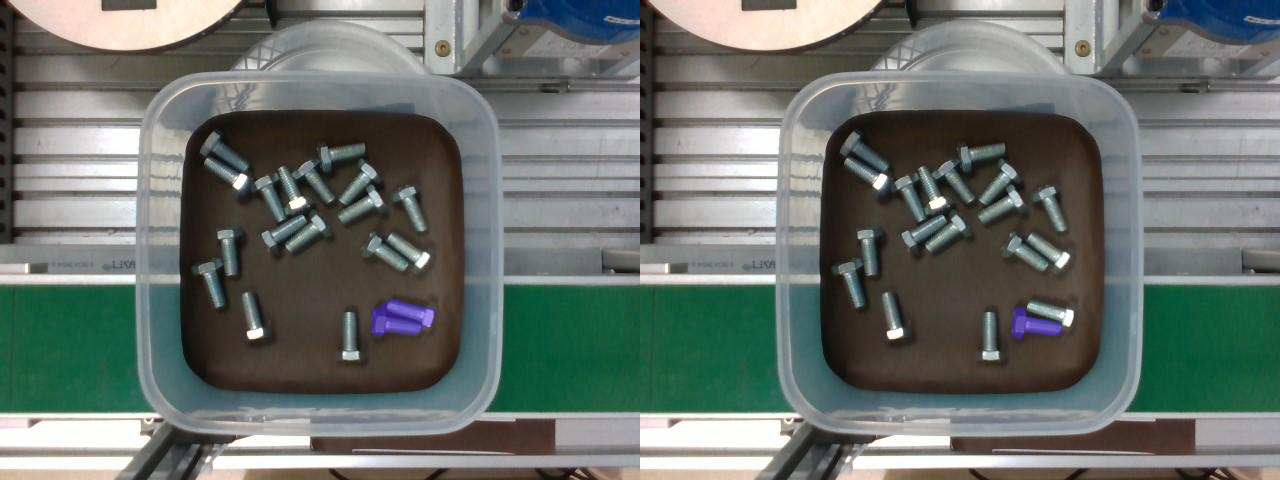

In [15]:
clip_together_imgs(mask_to_img(pred_mask > 0,img),mask_to_img(gt_binary_mask,img))

In [25]:
from glob import glob
%cd runs/

run_cfgs = glob('cfg_*.json')
highest_run = max([int(cfg.split('_')[1].split('.')[0]) for cfg in run_cfgs])
run_num = highest_run + 1
print(f"Run number: {run_num}")

dataset_path = dataset.location
import os
dataset_name = os.path.basename(dataset_path)

cfg = {
    "dataset_name": dataset_name,
    "use_cnn": use_cnn,
    "resize_before_cnn": resize_before_cnn,
    "grow_masks": grow_masks,
    "mask_lora": mask_lora,
    "mask_r": mask_r,
    "vit_lora": vit_lora,
    "vit_r": vit_r,
    "vit_patch_embed": vit_patch_embed,
    "initial_lr": initial_lr,
    "weight_decay": weight_decay,
    "warmup_steps": warmup_steps,
    "total_steps": total_steps,
    "batch_size": batch_size,
    "lr_decay_steps": lr_decay_steps,
    "lr_decay_factor": lr_decay_factor,
    "run_name":run.name,
    "run_url":run.url,
    "run_grad": run_grad,
    "use_masks": use_masks,
    "dice_scale": dice_scale,
    "focal_scale": focal_scale,
    "cls_scale": cls_scale,
    "num_classes": num_classes,
    "tasks": tasks,
    "use_valid": use_valid,
    "num_refinement_steps": num_refinement_steps,
}

with open(f'cfg_{run_num}.json', 'w') as f:
    json.dump(cfg, f)

torch.save(mask_decoder.state_dict(), f'mask_decoder_{run_num}.pt')
if use_cnn:
    torch.save(cnn_sam.state_dict(), f'ladder_{run_num}.pt')
if mask_lora:
    lora_mask_decoder.save_lora_parameters(f"mask_lora_{run_num}.pt")
if vit_lora:
    lora_image_encoder.save_lora_parameters(f"vit_lora_{run_num}.pt")
if vit_patch_embed:
    torch.save(image_encoder.patch_embed.state_dict(), f"vit_patch_embed_{run_num}.pt")
if num_classes > 0:
    torch.save(mask_decoder.class_tokens.state_dict(), f"class_tokens_{run_num}.pt")
    torch.save(mask_decoder.class_prediction_head.state_dict(), f"class_prediction_head_{run_num}.pt")

%cd ..

/home/andrewhealey/sam-fine-tuning/runs
Run number: 58
/home/andrewhealey/sam-fine-tuning


In [ ]:
evaluate()

  0%|          | 0/292 [00:00<?, ?it/s]

100%|██████████| 292/292 [00:48<00:00,  6.06it/s]

VALID - Loss: 0.6459


In [ ]:
from fine_tune.datasets import load_dir_as_dataset

test_dataset = load_dir_as_dataset("datasets/own-plate-test")

test_curr_dataset = prep_datasets(test_dataset)


100%|██████████| 7/7 [00:00<00:00, 3450.48it/s]


In [ ]:
idx = -1

one mask
Loss: 0.1740, Focal Loss: 0.0081, Dice Loss: 0.1660, IoU Loss: 0.2845
Predicted IoU: 0.47732868790626526


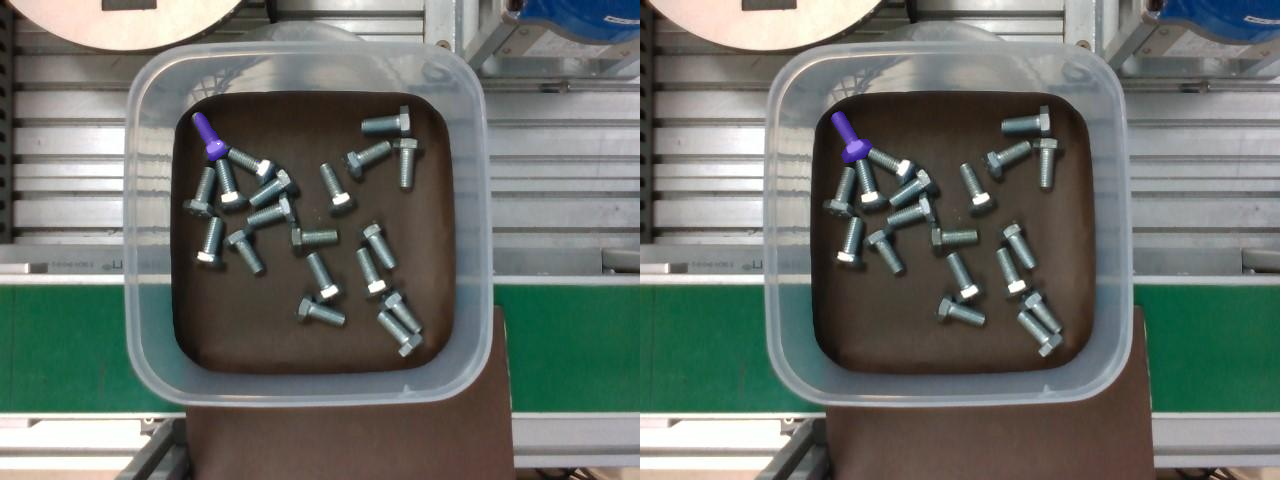

In [37]:
from random import randint

v_c_ds = valid_curr_dataset
idx = randint(0,len(v_c_ds)-1)

decoder_input, gt_masks, gt_cls_logits, (input_size,original_size), img, (unresized_img,resized_img) = v_c_ds[idx]
has_fresh_prompt = True
num_refinements_left = num_refinement_steps
new_input = {**decoder_input}
while has_fresh_prompt:
    has_fresh_prompt = False

    print("one mask" if len(gt_masks) == 1 else "multiple masks")

    with torch.no_grad():
        if use_cnn:
            cnn_embedding = cnn_sam(unresized_img,resized_img)[0]
            curr_embedding = decoder_input["image_embeddings"]
            new_input["image_embeddings"] = curr_embedding + cnn_embedding
        low_res_masks, iou_predictions, cls_pred_logits = mask_decoder(**new_input)

    # upscaled_masks = F.interpolate(low_res_masks, size=img.shape[:2], mode="bilinear", align_corners=False)
    upscaled_masks = predictor.model.postprocess_masks(low_res_masks, input_size, original_size).to(device)
    binary_masks = normalize(threshold(upscaled_masks + 0.1, 0.0, 0)).to(device)[0,:,:,:]

    max_idx = torch.argmax(iou_predictions).item()
    iou = iou_predictions[max_idx].item()

    gt_binary_mask, binary_mask,*_ = get_max_iou_masks(gt_masks,binary_masks)
    binary_mask = binary_masks[max_idx]

    if num_refinements_left > 0:
        has_fresh_prompt = True
        num_refinements_left -= 1

        new_prompt = make_refinement_prompt(binary_mask, gt_binary_mask)
        new_decoder_input, gt_masks = curr_dataset.prompt_to_tensors(new_prompt, sizing)

        # extract image_embeddings and context_embeddings from old decoder_input
        new_input = {
                    **new_input,
                    "dense_prompt_embeddings": decoder_input["dense_prompt_embeddings"],
                    # "image_embeddings": decoder_input["image_embeddings"],
                    # "context_embeddings": decoder_input["context_embeddings"],
                    # **new_decoder_input,
        }



from PIL import Image
import numpy as np

from persam.persam_f import calculate_iou_loss, calculate_dice_loss, calculate_sigmoid_focal_loss

with torch.no_grad():

    pred_logits = cls_pred_logits[0,max_idx]
    assert pred_logits.shape == (mask_decoder.num_classes,),f"pred_logits.shape: {pred_logits.shape}"
    if gt_cls_logits is None:
        cls_loss = 0
    else:
        cls_loss = bce(pred_logits, gt_cls_logits[0].to(device))

    flat_binary_mask = binary_mask.view(1,-1)
    flat_gt_binary_mask = gt_binary_mask.view(1,-1)

    focal_loss = calculate_sigmoid_focal_loss(flat_binary_mask, flat_gt_binary_mask,should_sigmoid=False)
    dice_loss = calculate_dice_loss(flat_binary_mask, flat_gt_binary_mask, should_sigmoid=False)
    iou_loss = calculate_iou_loss(flat_binary_mask, flat_gt_binary_mask, should_sigmoid=False)
    loss = focal_loss + dice_loss
    print(f"Loss: {loss:.4f}, Focal Loss: {focal_loss:.4f}, Dice Loss: {dice_loss:.4f}, IoU Loss: {iou_loss:.4f}")

print("Predicted IoU:",iou)
# print("Predicted class:",torch.argmax(pred_logits).item(),"GT class:",torch.argmax(gt_cls_logits[0]).item())

clip_together_imgs(mask_to_img(binary_mask,img),mask_to_img(gt_binary_mask,img))

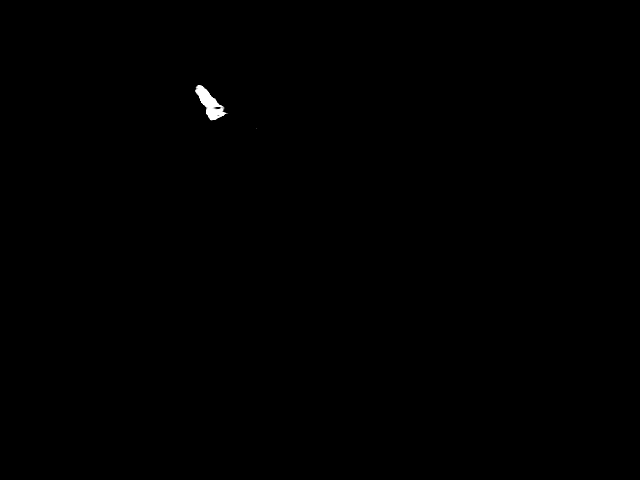

In [38]:
upscaled_masks = F.interpolate(low_res_masks, size=img.shape[:2], mode="bilinear", align_corners=False)
# upscaled_masks = predictor.model.postprocess_masks(low_res_masks, input_size, original_size).to(device)

Image.fromarray(upscaled_masks.cpu().numpy()[0,0] * 255).convert("RGB")

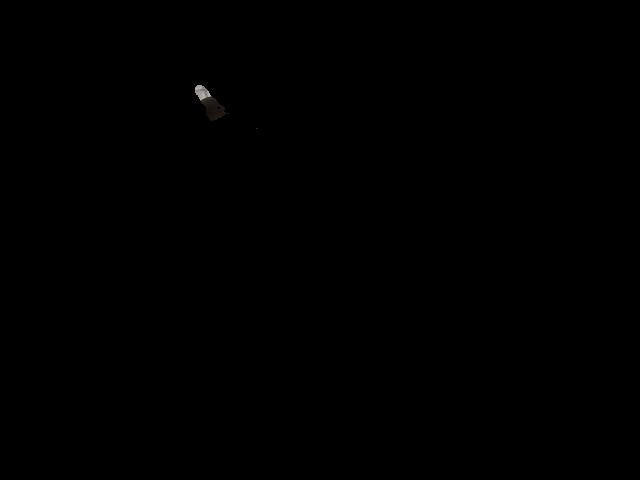

In [40]:
# upscale low_res_masks to 1024x1024
high_res_masks = F.interpolate(low_res_masks, size=img.shape[:2], mode="bilinear", align_corners=False).detach().cpu().numpy()[0,0]

thresholded = (high_res_masks > 0).astype(np.uint8)
Image.fromarray(img * thresholded[...,None]).convert("RGB")

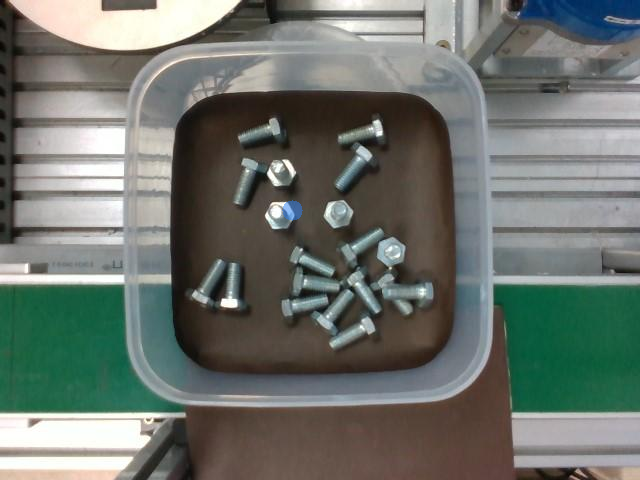

In [46]:
from random import choice
import fine_tune.viz

name,prompt = choice(curr_dataset.prompts)
# print(prompt.mask.shape)
render_prompt(name,prompt,train_dataset)

# Predict on Test Set

# Segment Everything

In [ ]:
from segment_anything import SamAutomaticMaskGenerator
from segment_anything import automatic_mask_generator
from persam.load import load_predictor
import cv2

model = load_predictor("vit_h").model.cuda()
# model.mask_decoder = mask_decoder

img = cv2.imread("demo-img.png")#list(train_dataset.images.values())[0]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# raise NotImplementedError("TODO: fix this")

mask_generator = SamAutomaticMaskGenerator(model,stability_score_thresh=0.1)
print(f"Model threshold: {model.mask_threshold}, offset: {mask_generator.stability_score_offset}")

sam_result = mask_generator.generate(img)
raw_masks = automatic_mask_generator.latest_masks

if len(sam_result) == 0:
    print("No detections found")
    raise NotImplementedError("TODO: fix this")
detections = sv.Detections.from_sam(sam_result=sam_result)

annotator = sv.MaskAnnotator()
# paste each image into the new image
# detections = pred_dataset.annotations[img_name]
tmp_img = annotator.annotate(scene=img,detections=detections)
tmp_img = Image.fromarray(tmp_img)

tmp_img

In [ ]:
from PIL import Image
import numpy as np
print(raw_masks.shape,raw_masks.dtype)
Image.fromarray(raw_masks[0].detach().cpu().numpy().astype(np.uint8) * 255)

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "weights/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
from fine_tune.samed import LoRA_Mask_Decoder

lora_mask_decoder = LoRA_Mask_Decoder(sam.mask_decoder,r=5)

lora_mask_decoder.load_lora_parameters("lora.pt")
mask_decoder = lora_mask_decoder.mask_decoder.cuda()

In [ ]:
import cv2
img = cv2.imread("demo-img.png")#list(train_dataset.images.values())[0]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

masks = mask_generator.generate(img)

masks

# Distance utils

In [ ]:
from supervision.dataset.utils import approximate_mask_with_polygons

from random import choice
rand_img_name = choice(list(train_dataset.images.keys()))

rand_img_dets = train_dataset.annotations[rand_img_name]

biggest_mask = rand_img_dets.mask[rand_img_dets.area.argmax()]

from supervision.dataset.utils import approximate_mask_with_polygons
def dets_to_polygonss(dets):
    polygons = []
    for _,det_mask,*_ in dets:
        polygons.append(approximate_mask_with_polygons(det_mask))
    return polygons

def get_distances(point, polygonss):
    distances = np.zeros(len(polygonss), dtype=np.float32)
    for i,polygons in enumerate(polygonss):
        distances[i] = min([-cv2.pointPolygonTest(polygon, point, True) for polygon in polygons])
    
    distances = np.maximum(distances, 0)
    return distances

def show_closest_distances(point, dets):
    # get the distance of each det
    polygonss = dets_to_polygonss(dets)
    distances = get_distances(point, polygonss)

    # render the masks with their respective distances
    empty_map = np.zeros_like(dets.mask[0], dtype=np.float32)

    for i,(_,det_mask,*_) in enumerate(dets):
        empty_map[det_mask] = distances[i]

    return empty_map

polygons = approximate_mask_with_polygons(biggest_mask)

# make a signed distance map
empty_map = np.zeros(biggest_mask.shape, dtype=np.float32)

for i in range(biggest_mask.shape[0]):
    for j in range(biggest_mask.shape[1]):
        redPoint = (j,i)
        closestDist = cv2.pointPolygonTest(polygons[0], redPoint, True)

        empty_map[i, j] = -closestDist

empty_map = np.maximum(empty_map, 0)

from matplotlib import pyplot as plt

rand_point = (choice(range(biggest_mask.shape[0])), choice(range(biggest_mask.shape[1])))

plt.imshow(show_closest_distances(rand_point, rand_img_dets))

# Progressive mask gen

In [ ]:
import supervision as sv

class LabellingSession:
    def __init__(self,img:np.ndarray):
        self.img = img
        self.sv_dataset = sv.DetectionDataset(
            classes=train_dataset.classes,
            images={
                "test":img
            },
            annotations={
                "test":sv.Detections.empty()
            }
        )
        self.torch_dataset = SamNextMaskDataset(self.sv_dataset,predictor,device)
        self.annotator = sv.MaskAnnotator()
    
    def update_detections(self,detections:sv.Detections):
        self.sv_dataset.annotations["test"] = detections

    def img_to_tensors(self):
        return self.torch_dataset[0]
    
    def show(self):
        return Image.fromarray(self.annotator.annotate(scene=self.img,detections=self.sv_dataset.annotations["test"]))
    
    @torch.no_grad()
    def get_next_mask(self):
        decoder_input, _, (input_size,original_size), img, (unresized_img,resized_img) = self.img_to_tensors()
        H,W,_ = img.shape

        new_input = {**decoder_input}

        if vit_lora:
            sam_embedding = image_encoder(resized_img)[0]
            new_input["image_embeddings"] = sam_embedding

        if use_cnn:
            cnn_embedding = cnn_sam(unresized_img,resized_img)[0]

            curr_embedding = new_input["image_embeddings"]

            new_input["image_embeddings"] = curr_embedding + cnn_embedding

        low_res_masks, iou_predictions = mask_decoder(**new_input)

        high_res_masks = F.interpolate(
                low_res_masks,
                (H, W),
                mode="bilinear",
                align_corners=False,
            )
        high_res_masks = high_res_masks.squeeze(0)
        assert len(high_res_masks.shape) == 3,f"Shape is {high_res_masks.shape}" # 1 or 3, H, W

        assert len(iou_predictions.shape) == 1, f"IoU predictions shape is {iou_predictions.shape}"

        pred_idx = torch.argmax(iou_predictions)
        pred_mask = high_res_masks[pred_idx] > 0

        # new detection
        masks = pred_mask[None, :, :].cpu().numpy()
        class_id = 0
        new_dets = sv.Detections(
            xyxy=sv.Detections.mask_to_xyxy(masks),
            mask=masks,
            class_id=np.array([class_id]),
        )

        self.update_detections(new_dets)


In [ ]:
demo_img = cv2.imread("test.jpg")

session = LabellingSession(demo_img)

In [ ]:
session.get_next_mask()

session.show